# Appendix D
I am using "The Pit and the Pendulum" by Edgar Allan Poe (which is in the public domain) instead of "The Verdict" to get some novel results.

In [1]:
# Reinitialize the model
import torch
from previous_chapters import GPTModel
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();

In [2]:
# Import the text data
file_path = "pit-and-pendulum.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [3]:
# Load the text data into the data loaders
from previous_chapters import create_dataloader_v1
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
torch.manual_seed(123)
train_loader = create_dataloader_v1(
    text_data[:split_idx],
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0)
val_loader = create_dataloader_v1(
    text_data[split_idx:],
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0)

# D.1 - Learning rate warmup

In [4]:
# Prepare the warmup
n_epochs = 15
initial_lr = 0.0001
peak_lr = 0.01
# warmup_steps = 20
total_steps = len(train_loader) * n_epochs
warmup_steps = int(0.2 * total_steps)
print(warmup_steps)

39


In [5]:
# Implement a simple training loop
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)
lr_increment = (peak_lr - initial_lr) / warmup_steps
global_step = -1
track_lrs = []
for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1
        if global_step < warmup_steps:
            lr = initial_lr + global_step * lr_increment
        else:
            lr = peak_lr
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        track_lrs.append(optimizer.param_groups[0]["lr"])

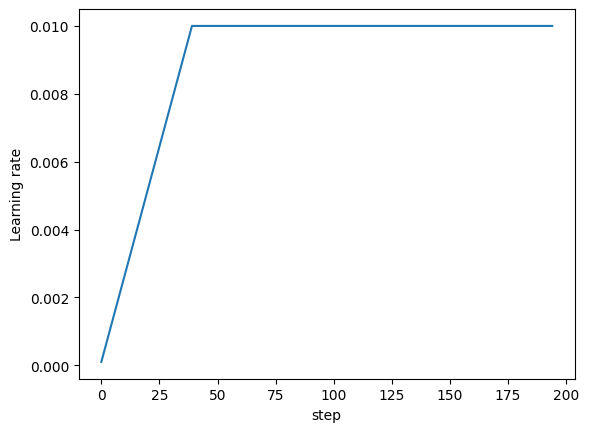

In [6]:
# Visualize how the learning rate was changed
import matplotlib.pyplot as plt
plt.ylabel("Learning rate")
plt.xlabel("step")
total_training_steps = len(train_loader) * n_epochs
plt.plot(range(total_training_steps), track_lrs)
plt.show()

# D.2 - Cosine decay

In [10]:
# Prepare the cosine decay
import math
min_lr = 0.1 * initial_lr
track_lrs = []
lr_increment = (peak_lr - initial_lr) / warmup_steps
global_step = -1

In [11]:
# Modify the training loop by adding cosine decay
for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1
        if global_step < warmup_steps:
            lr = initial_lr + global_step * lr_increment  
        else:
            progress = ((global_step - warmup_steps) / (total_training_steps - warmup_steps))
            lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        track_lrs.append(optimizer.param_groups[0]["lr"])

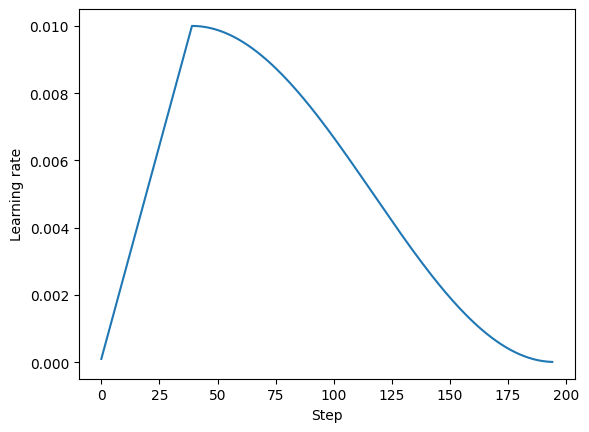

In [12]:
# Verify the learning rate has changed as intended
plt.ylabel("Learning rate")
plt.xlabel("Step")
plt.plot(range(total_training_steps), track_lrs)
plt.show()